In [812]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [813]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72
DEBUG = False

In [814]:
def generate_a_drawing(figsize, U, V, noise=0.0):
  fig = plt.figure(figsize=(figsize,figsize))
  ax = plt.subplot(111)
  plt.axis('Off')
  ax.set_xlim(0,figsize)
  ax.set_ylim(0,figsize)
  ax.fill(U, V, "k")
  fig.canvas.draw()
  imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
  imdata = imdata + noise * np.random.random(imdata.size)
  plt.close(fig)
  return imdata

In [815]:
def generate_a_rectangle(noise=0.0, free_location=False):
  figsize = 1.0
  U = np.zeros(4)
  V = np.zeros(4)
  if free_location:
    corners = np.random.random(4)
    top = max(corners[0], corners[1])
    bottom = min(corners[0], corners[1])
    left = min(corners[2], corners[3])
    right = max(corners[2], corners[3])
  else:
    side = (0.3 + 0.7 * np.random.random()) * figsize
    top = figsize/2 + side/2
    bottom = figsize/2 - side/2
    left = bottom
    right = top
  U[0] = U[1] = top
  U[2] = U[3] = bottom
  V[0] = V[3] = left
  V[1] = V[2] = right
  return generate_a_drawing(figsize, U, V, noise)

In [816]:
def generate_a_disk(noise=0.0, free_location=False):
  figsize = 1.0
  if free_location:
    center = np.random.random(2)
  else:
    center = (figsize/2, figsize/2)
  radius = (0.3 + 0.7 * np.random.random()) * figsize/2
  N = 50
  U = np.zeros(N)
  V = np.zeros(N)
  i = 0
  for t in np.linspace(0, 2*np.pi, N):
    U[i] = center[0] + np.cos(t) * radius
    V[i] = center[1] + np.sin(t) * radius
    i = i + 1
  return generate_a_drawing(figsize, U, V, noise)

In [817]:
def generate_a_triangle(noise=0.0, free_location=False):
  figsize = 1.0
  if free_location:
    U = np.random.random(3)
    V = np.random.random(3)
  else:
    size = (0.3 + 0.7 * np.random.random())*figsize/2
    middle = figsize/2
    U = (middle, middle+size, middle-size)
    V = (middle+size, middle-size, middle-size)
  imdata = generate_a_drawing(figsize, U, V, noise)
  return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

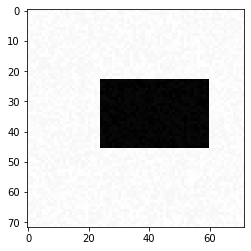

In [818]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

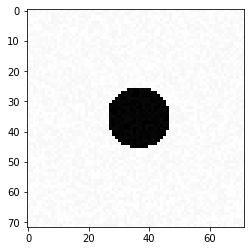

In [819]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

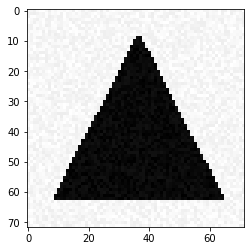

In [820]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [821]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
  # Getting im_size:
  im_size = generate_a_rectangle().shape[0]
  X = np.zeros([nb_samples, im_size])
  Y = np.zeros(nb_samples)
  if (DEBUG):
    print('Creating data:')
  for i in range(nb_samples):
    if (DEBUG):
      if i % 10 == 0:
        print(i)
    category = np.random.randint(3)
    if category == 0:
      X[i] = generate_a_rectangle(noise, free_location)
    elif category == 1:
      X[i] = generate_a_disk(noise, free_location)
    else:
      [X[i], V] = generate_a_triangle(noise, free_location)
    Y[i] = category
  X = (X + noise) / (255 + 2 * noise)
  return [X, Y]

In [822]:
def generate_test_set_classification():
  np.random.seed(42)
  [X_test, Y_test] = generate_dataset_classification(300, 20, True)
  Y_test = np_utils.to_categorical(Y_test, 3)
  return [X_test, Y_test]

In [823]:
def generate_dataset_regression(nb_samples, noise=0.0):
  # Getting im_size:
  im_size = generate_a_triangle()[0].shape[0]
  X = np.zeros([nb_samples, im_size])
  Y = np.zeros([nb_samples, 6])
  if (DEBUG):
    print('Creating data:')
  for i in range(nb_samples):
    if (DEBUG):
      if i % 10 == 0:
        print(i)
    [X[i], Y[i]] = generate_a_triangle(noise, True)
  X = (X + noise) / (255 + 2 * noise)
  return [X, Y]

In [824]:
def visualize_prediction(x, y):
  fig, ax = plt.subplots(figsize=(5, 5))
  I = x.reshape((IMAGE_SIZE, IMAGE_SIZE))
  ax.imshow(I, extent=[-0.15, 1.15, -0.15, 1.15], cmap='gray')
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])

  xy = y.reshape(3, 2)
  tri = patches.Polygon(xy, closed=True, fill=False,
                        edgecolor='r', linewidth=5, alpha=0.5)
  ax.add_patch(tri)

  plt.show()

In [825]:
def generate_test_set_regression():
  np.random.seed(42)
  [X_test, Y_test] = generate_dataset_regression(300, 20)
  return [X_test, Y_test]

In [826]:
from tensorflow import keras
from tensorflow.keras import utils as np_utils

In [827]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

1.

In [828]:
num_classes = 3
X_train_False, Y_train_False = generate_dataset_classification(300, 20)
X_test_False, Y_test_False = generate_dataset_classification(300, 20)

Y_train_False = np_utils.to_categorical(Y_train_False, num_classes)
Y_test_False = np_utils.to_categorical(Y_test_False, num_classes)

num_pixels = X_train_False.shape[1] # 72 * 72

In [829]:
def showAccuracies(hist):
  # plot accuracies
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

2.

In [830]:
#  hyper-paramètres
epochs = 10 # 20
batch_size = 64 # 128
num_neurons = 128 # num_pixels

In [831]:
def simpleModel():
  model = Sequential()
  model.add(Dense(num_neurons, input_dim=num_pixels,
            activation='relu', kernel_initializer='normal'))
  model.add(Dense(num_classes, input_dim=num_neurons,
            activation='softmax', kernel_initializer='normal'))
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam', metrics=['accuracy'])
  # Adam sgd
  return model


In [832]:
model = simpleModel()
model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 128)               663680    
_________________________________________________________________
dense_201 (Dense)            (None, 3)                 387       
Total params: 664,067
Trainable params: 664,067
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5/5 [==============================] - 0s 39ms/step - loss: 3.1876 - accuracy: 0.3300 - val_loss: 1.7010 - val_accuracy: 0.3167
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 1.6654 - accuracy: 0.4167 - val_loss: 1.3086 - val_accuracy: 0.4500
Epoch 3/10
5/5 [==============================] - 0s 11ms/step - loss: 1.0373 - accuracy: 0.4533 - val_loss: 1.2065 - val_accuracy: 0.3900
Epoch 4/10
5/5 [==============================] - 0s 11ms/step - loss: 1.0956 - accuracy: 0.4600 - val_loss: 0.8586 - val_accuracy: 0.4533
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 0.7977 - accuracy: 0.6767 - val_loss: 0.7996 - val_accuracy: 0.6867
Epoch 6/10
5/5 [==============================] - 0s 13ms/step - loss: 0.7725 - accuracy: 0.7300 - val_loss: 0.6737 - val_accuracy: 0.8767
Epoch 7/10
5/5 [==============================] - 0s 12ms/step - loss: 0.6522 - accuracy: 0.9000 - val_loss: 0.6648 - val_accuracy: 0.9167
Epoch 8/10
5/5 [===========

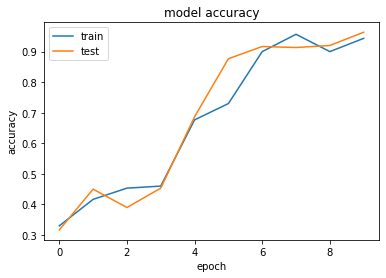

In [833]:
hist = model.fit(X_train_False, Y_train_False, validation_data=(
    X_test_False, Y_test_False), epochs=epochs, batch_size=batch_size)
scores = model.evaluate(X_test_False, Y_test_False)
print("Test loss: %.2f%%" % (scores[0]))
print("Test accuracy: %.2f%%" % (scores[1] * 100))
showAccuracies(hist)

J'ai trouver les `hyper-paramètres` suivant :
- 2 `couches` de neurones
- Peut importe le `batch_size` tant qu'il est pas trop petit.
- Peut importe le nombre de neurones tant qu'il est superieur a `15`.
- J'ai mis un nombre d'`epochs`, de `10` pour atteindre une `accuracy` superieur à 80%.
- L'optimiseur `Adam` est le meilleur.

3.

In [834]:
X_train, Y_train = generate_dataset_classification(300, 20, True)
X_test, Y_test = generate_dataset_classification(300, 20, True)

Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

`formsNonFree` = forms créer avec `free_location=False`<br>
`formsFree` = forms créer avec `free_location=False`

Evaluation du model qui est train avec des `formsNonFree` qu'on test avec des `formsFree`:

In [837]:
scores = model.evaluate(X_test, Y_test)
print("Test loss: %.2f%%" % (scores[0]))
print("Test accuracy: %.2f%%" % (scores[1] * 100))

10/10 [==============================] - 0s 3ms/step - loss: 1.3212 - accuracy: 0.3733
Test loss: 1.32%
Test accuracy: 37.33%


Je vois que c'est pas top l'`accuracy` est aux alentour de `35%`.

Evaluation du model qui est train avec des `formsFree` qu'on test avec des `formsFree`:

Epoch 1/10
5/5 [==============================] - 1s 49ms/step - loss: 3.0185 - accuracy: 0.3933 - val_loss: 1.8011 - val_accuracy: 0.3033
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 1.5264 - accuracy: 0.3600 - val_loss: 1.2184 - val_accuracy: 0.3167
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 1.1255 - accuracy: 0.4100 - val_loss: 1.3476 - val_accuracy: 0.3167
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 1.2229 - accuracy: 0.4500 - val_loss: 1.0585 - val_accuracy: 0.4800
Epoch 5/10
5/5 [==============================] - 0s 20ms/step - loss: 1.0751 - accuracy: 0.4000 - val_loss: 1.0935 - val_accuracy: 0.3233
Epoch 6/10
5/5 [==============================] - 0s 26ms/step - loss: 1.0454 - accuracy: 0.4033 - val_loss: 1.0188 - val_accuracy: 0.5133
Epoch 7/10
5/5 [==============================] - 0s 24ms/step - loss: 1.0098 - accuracy: 0.5300 - val_loss: 1.0190 - val_accuracy: 0.5133
Epoch 8/10
5/5 [===========

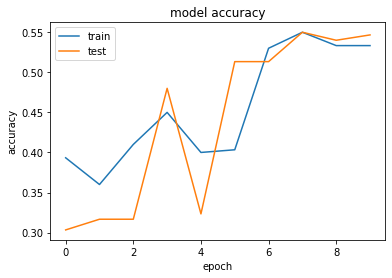

In [852]:
model = simpleModel()
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size)
scores = model.evaluate(X_test, Y_test)
print("Test loss: %.2f%%" % (scores[0]))
print("Test accuracy: %.2f%%" % (scores[1] * 100))
showAccuracies(hist)

Evaluation du model qui est train avec des `formsFree` qu'on test avec des `formsNonFree`:

In [853]:
scores = model.evaluate(X_test_False, Y_test_False)
print("Test loss: %.2f%%" % (scores[0]))
print("Test accuracy: %.2f%%" % (scores[1] * 100))

10/10 [==============================] - 0s 2ms/step - loss: 1.1076 - accuracy: 0.4700
Test loss: 1.11%
Test accuracy: 47.00%


Je vois que le test de l'`accuracy` de ce nouveau model est aux alentour de `50%` quant on le test avec des `formsFree` et environ `10%` de moins quant on le test avec des `formsNonFree`.

4.

In [687]:
X_test, Y_test = generate_test_set_classification()

In [688]:
# visualize_prediction
# generate_dataset_regression
# generate_test_set_regression